In [1]:
# These package is inherited from Lenard-Jones optimization part of DMFF

import openmm.app as app
import openmm as mm
import openmm.unit as unit
import numpy as np
import jax
import jax.numpy as jnp
import dmff
from dmff.api.xmlio import XMLIO
from dmff.api.paramset import ParamSet
from dmff.generators.classical import CoulombGenerator, LennardJonesGenerator
from dmff.api.hamiltonian import Hamiltonian
from dmff.operators import ParmedLennardJonesOperator
from dmff import NeighborListFreud
from dmff.mbar import ReweightEstimator
import mdtraj as md
from tqdm import tqdm, trange
import parmed
import sys
import os
from dmff.api.topology import DMFFTopology
# this is a package I write to solve some IO problems utils.py
from utils import create_supercell, gas_generate,add_loading, simple_merge
from utils import cutoff_topology
import matplotlib.pyplot as plt
import optax
from utils import extract_from_raspa

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
"""

Superparameters for Lenard-Jone Potential optimization

"""
particle_number =  500             #液体pdb文件中的分子数
target_site1 = -50.60                  #拟合的目标binding energy
target_site2 = -46.69           #拟合的目标binding energy
SET_temperature=  303          #温度设定 For simulated isotherm
time_gap=   2.2                      #分子动力学模拟过程中每一个frame的时间间隔，单位是皮秒picosecond   推荐2-4ps
loop_time =   100                  #迭代循环次数    推荐50-100
scaling_factors = (3,3,2)
cutoff = 0.905 #1.3 # unit is nanometer

In [5]:
# this is some self-defined functions for testing the model

# These package is inherited from Lenard-Jones optimization part of DMFF

import openmm.app as app
import openmm as mm
import openmm.unit as unit
import numpy as np
import jax
import jax.numpy as jnp
import dmff
from dmff.api.xmlio import XMLIO
from dmff.api.paramset import ParamSet
from dmff.generators.classical import CoulombGenerator, LennardJonesGenerator
from dmff.api.hamiltonian import Hamiltonian
from dmff.operators import ParmedLennardJonesOperator
from dmff import NeighborListFreud
from dmff.mbar import ReweightEstimator
import mdtraj as md
from tqdm import tqdm, trange
import parmed
import sys
import os
from dmff.api.topology import DMFFTopology
# this is a package I write to solve some IO problems utils.py
from utils import create_supercell, gas_generate,add_loading, simple_merge
from utils import cutoff_topology
import matplotlib.pyplot as plt
import optax
from utils import extract_from_raspa
from IPython.display import display
"""

Superparameters for Lenard-Jone Potential optimization

"""
Number_points = 2           ## must be smaller than len(picked_ls)
Trajectory_length = 250#250          #液体pdb文件的个数
target_site1 = -50.60                  #拟合的目标binding energy
target_site2 = -46.69           #拟合的目标binding energy
SET_temperature=  303           #温度设定
time_gap=   2.2                      #分子动力学模拟过程中每一个frame的时间间隔，单位是皮秒picosecond   推荐2-4ps
loop_time =   100                  #迭代循环次数    推荐50-100
scaling_factors = (3,3,2)
cutoff = 0.905     #1.3 # unit is nanometer

Transfer_unit = 2.7719416667/5.6100437023 



pressure_list = [
            0.021648873072361,
            0.038256227758007,
            0.059015421115065,
            0.077698695136418,
            0.09638196915777,
            0.14827995255042,
            0.20017793594306,
            0.24584816132859,
            0.29774614472123,
            0.34756820877817,
            0.39739027283511,
            0.44928825622776,
            0.49495848161329,
            0.60083036773428,
            0.69839857651246,
            0.80219454329775,
            0.90183867141163,
            0.99733096085409,
            1.1986951364176,
            1.3959074733096,
            1.5993475682088,
            1.7986358244365,
            2.0020759193357
        ]

arr_3 = np.loadtxt("/home/yutao/dataset/exp_303.txt", delimiter=',')

picked_ls = list(range(Number_points))#[0,1,2,3,4,5,6,7,8,9] #[0, 2, 4, 6, 8, 10, 14, 18, 22]#[0, 3, 6, 9, 12, 15, 18]
picked_pressure = [pressure_list[i] for i in picked_ls]
#print(picked_pressure)
#picked_isotherm = [arr_3[i,1]*Transfer_unit*2/1.5 for i in picked_ls]
picked_isotherm = [arr_3[i,1]*Transfer_unit for i in picked_ls]
def is_close_to_list(value, value_list):
    for list_value in value_list:
        relative_error = abs((value - list_value) / list_value)
        if relative_error < 0.01:
            return 1
    return 0

import os
import numpy as np
from utils import scaling_gas, extract_from_raspa, write_scaling_gas
bar = 10**5
def move_traj(dest_path = "/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/"):
    traj_ls = os.listdir(dest_path)
    isotherm_data = [[],[]] # the first list is for pressure, the second is for loading
    jdx = 0 
    for traj in extract_from_raspa(traj_ls):
        pdb_file = traj[1]
        if not pdb_file.endswith(".pdb") or 'Movie_framework' not in pdb_file:
            continue
        if not is_close_to_list(float(traj[0])/bar, picked_pressure):
            continue
        isotherm_data[0].append(float(traj[0])/bar)
        pdb_path = os.path.join(dest_path, pdb_file)
        with open(pdb_path) as f:
            lines = f.readlines()
        num_atoms_list = []  # List to store the number of atoms in each structure
        index = 0
        write_idx = 1
        num_atoms = 0  # Variable to store the number of atoms in the current structure
        directory = copy_to_path+f"{jdx+1}"
        jdx += 1
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("Directory created:", directory)
        for line in lines:
            if line.startswith("MODEL"):
                if index>=150:
                    write_scaling_gas(block_coords, "data/gas.pdb", write_idx, dest_path=directory)
                    write_idx += 1
                block_coords = []
                block_Csym = []
                index += 1
                num_atoms_list.append(num_atoms)  # Add the number of atoms to the list
                num_atoms = 0  # Reset the number of atoms for the next structure
            if line.startswith("ATOM"):
                parts = line.split()
                coords = np.array([float(parts[4]), float(parts[5]), float(parts[6])])
                block_coords.append(coords)
                block_Csym.append(parts[-1])
                num_atoms += 1  # Increment the number of atoms
        #num_atoms_list.append(num_atoms)  # Add the number of atoms for the last structure
        isotherm_data[1].append(sum(num_atoms_list)/len(num_atoms_list)/3/3/2/3)
        #print("Number of atoms in each structure for", pdb_file, ":", num_atoms_list)
    return isotherm_data

def update_mask(parameters, mask):
    updated_parameters = parameters.copy()
    
    for force_type, force_params in mask.items():
        if force_type in parameters:
            for param, mask_array in force_params.items():
                if param in parameters[force_type]:
                    # Update values based on the mask
                    updated_parameters[force_type][param] = jnp.where(mask_array == 1, 
                                                                      parameters[force_type][param], 
                                                                      0)
    return updated_parameters

def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

def detect_parameter_change(paramset_new, paramset_old, error_threshold=0.4):
    # Get the initial parameters
    initial_sigma = paramset_old.parameters['LennardJonesForce']['sigma']
    initial_epsilon = paramset_old.parameters['LennardJonesForce']['epsilon']
    
    # Get the updated parameters
    updated_sigma = paramset_new.parameters['LennardJonesForce']['sigma']
    updated_epsilon = paramset_new.parameters['LennardJonesForce']['epsilon']
    
    # Calculate the percentage change for each parameter
    sigma_change = np.abs(updated_sigma - initial_sigma) / initial_sigma
    epsilon_change = np.abs(updated_epsilon - initial_epsilon) / initial_epsilon

    # Find the indices of values that have changed by more than 40%
    sigma_indices = np.where(sigma_change > error_threshold)[0]
    epsilon_indices = np.where(epsilon_change > error_threshold)[0]
    
    return sigma_indices, epsilon_indices

def fix_changed_parameters(paramset_new, sigma_indices, epsilon_indices):
    for idx in sigma_indices:
        paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[idx].set(0)
    for idx in epsilon_indices:
        paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[idx].set(0)
    return paramset_new


import json
Transfer_energy_unit = 254.152/2.11525
Transfer_length_unit = 10
def update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_2.json'):
    global Transfer_energy_unit, Transfer_length_unit
    element_list = ['Al_', 'C_', 'H_', 'O_']
    params = paramset.parameters
    ff_data = {}
    if len(element_list) != params['LennardJonesForce']['sigma'].shape[0]-2:
        raise ValueError("Length of element list and parameter list does not match")
    sigma_list = params['LennardJonesForce']['sigma'].tolist()
    epsilon_list = params['LennardJonesForce']['epsilon'].tolist()
    for idx in range(len(element_list)):
        ff_data[element_list[idx]] = ['lennard-jones', epsilon_list[idx]*Transfer_energy_unit, sigma_list[idx]*Transfer_length_unit]
    with open(dest_path, 'w') as f:
        json.dump(ff_data, f, indent=4)

from jax import clear_backends
def analyse_traj(paramset, lj_gen, dest_path = "./traj1/", interval=3):
    traj_dict = {}
    global Number_points, cutoff
    traj_ls = os.listdir(dest_path)
    create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")

    # Filter out file names and keep only directory names
    dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]
    dir_names = sorted(map(int, dir_names))
    dir_names = [str(i) for i in dir_names]
    for directory in dir_names[:Number_points]:
        idx = int(directory)
        traj_dict[idx] = {'experiment': {'pressure': picked_pressure[idx-1], 'loading': picked_isotherm[idx-1]}, 'structure': [], 'refer_energy':[], 'loading':[]}
        gas_dir = os.path.join(dest_path, directory)
        for gas_path in os.listdir(gas_dir)[::interval]:
            topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
            ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)
            traj_dict[idx]['structure'].append([topo, pos])
            traj_dict[idx]['loading'].append(num/scaling_factors[0]/scaling_factors[1]/scaling_factors[2]/3)
            traj_dict[idx]['refer_energy'].append(ener_lj)
        clear_backends()
    for key in traj_dict.keys():
        traj_dict[key]['refer_energy'] = jnp.array(traj_dict[key]['refer_energy'])
        traj_dict[key]['loading'] = jnp.array(traj_dict[key]['loading'])
        traj_dict[key]['estimator'] = ReweightEstimator(ref_energies=traj_dict[key]['refer_energy'], temperature=SET_temperature)
    return traj_dict

import subprocess
def sample():
    command = ["/home/yutao/project/aiida/applications/sample_long.sh"]
    # Run the script using subprocess
    completed_process = subprocess.run(command, capture_output=True, cwd="/home/yutao/project/aiida/applications",text=True)
    print("As long as it finishes,",completed_process.returncode)
    # Check the return code
    if completed_process.returncode == 0:
        # The script finished successfully
        display("Script finished successfully!")
        # Display the output in the notebook
        display("Script output:")
        display(completed_process.stdout)
        # Continue with your program logic here
    else:
        # The script encountered an error
        display("Script encountered an error:", completed_process.stderr)
        # Handle the error or exit the program


In [6]:

# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()

paramset_old = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset_old)

xmlio = XMLIO()
#xmlio.loadXML("data/init.xml")
xmlio.loadXML("0219.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[1].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[2].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[3].set(0)
#paramset.mask['LennardJonesForce']['epsilon'] = paramset.mask['LennardJonesForce']['epsilon'].at[1].set(0)
optimizer = optax.adam(0.01)
opt_state = optimizer.init(paramset)



In [4]:
paramset.parameters

{'LennardJonesForce': {'sigma': Array([0.34309, 0.25711, 0.31181, 0.40082, 0.305  , 0.28   ], dtype=float64),
  'epsilon': Array([0.12956916, 0.04939106, 0.07208707, 1.57065054, 0.65757   ,
         0.22469   ], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64)}}

In [7]:
from jax import clear_caches, clear_backends
loss_ls = []
#os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_2.json")
os.system("cp 0219.json /home/yutao/project/aiida/applications/ff_2.json")
for nloop in range(3):
    print(f"{nloop} optimization started")
    #sample()
    move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=25)
    #print(len(traj_dict[1]['structure']))
    #print(traj_dict.keys())
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):  
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            #print(f"This is {jdx}th reweight_loading results from dmff code.",jnp.average(traj_dict[idx]['loading']),jnp.average(reweight_loading))
            error = jnp.abs(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'])
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset)
    lj_gen.overwrite(paramset)
    sigma_indices, epsilon_indices = detect_parameter_change(paramset, paramset_old,0.9)
    paramset = fix_changed_parameters(paramset, sigma_indices, epsilon_indices)
    print(f"This is {nloop}th time", f" Loss: {v} and Parameters: ",paramset.parameters['LennardJonesForce']['sigma'], paramset.parameters['LennardJonesForce']['epsilon'])
    clear_caches()
    clear_backends()    
   


0 optimization started
This is 0th time  Loss: 2.033250929509169 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.56065054 0.13956916 0.05939106 0.06208707 0.65757    0.22469   ]
1 optimization started
This is 1th time  Loss: 2.033250929509169 and Parameters:  [0.40082 0.34309 0.25711 0.31181 0.305   0.28   ] [1.55064972 0.14955775 0.06935648 0.05207459 0.65757    0.22469   ]
2 optimization started


KeyboardInterrupt: 

In [2]:
p_ls = [0.021648873072361, 0.077698695136418, 0.20017793594306, 0.34756820877817, 0.49495848161329, 0.80219454329775, 1.1986951364176]
loading = [0.2619537037,0.8122592593]

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("/home/yutao/project/github/DMFF/UFF_opt/pimd/")

exp_rdf = np.loadtxt("experiment.txt", delimiter=',')
bomd_rdf = np.loadtxt("multiplot_onebead_OO.dat")
aimd_rdf = np.loadtxt("multiplot_00.dat")
pimd_rdf = np.loadtxt("multiplot_bead32_OO.dat")

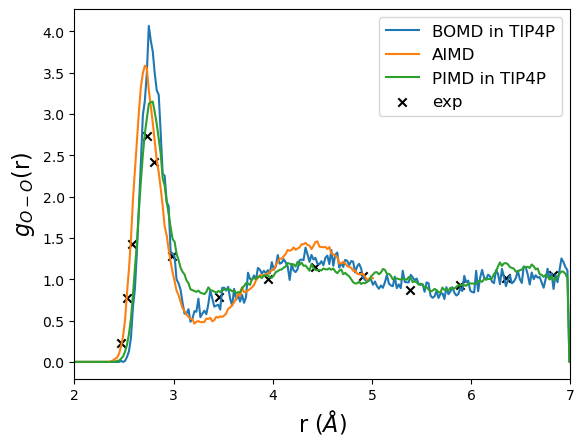

In [27]:
fz = 16
plt.plot(bomd_rdf[:,0],bomd_rdf[:,1],label="BOMD in TIP4P")
plt.plot(aimd_rdf[:,0],aimd_rdf[:,1],label="AIMD")
plt.plot(pimd_rdf[:,0],pimd_rdf[:,1],label="PIMD in TIP4P")
plt.scatter(exp_rdf[:,0],exp_rdf[:,1],label="exp",color="black",marker="x")
#plt.axvline(x=2.73126143, linestyle='dotted', color='red')
plt.xlim(2,7)
plt.ylabel(r'$g_{O-O}$(r)', fontsize=fz)
plt.xlabel(r'r ($\AA$)', fontsize=fz) 
plt.legend(fontsize=fz-4)

In [165]:
raspa_isotherm = dict({
    "loading_absolute_average": [
            4.1475461760433,
            4.1682795780048,
            4.2119051746019,
            4.2857088897951,
            4.3472569607212,
            4.4867689199957,
            4.4830809830163,
            4.5825316016782,
            4.6522988251158,
            4.5864669004446,
            4.751951830768,
            4.7789817105534,
            4.716635336276,
            4.7685250597767,
            4.747937826006,
            4.8892825099698,
            4.8383709892099,
            4.9311765750692,
            4.9275111254882,
            5.0058460562137,
            5.0193160212084,
            5.0315604218775,
            5.0003816129398
        ],
        "loading_absolute_unit": "mol/kg",
        "pressure": [
            0.021648873072361,
            0.038256227758007,
            0.059015421115065,
            0.077698695136418,
            0.09638196915777,
            0.14827995255042,
            0.20017793594306,
            0.24584816132859,
            0.29774614472123,
            0.34756820877817,
            0.39739027283511,
            0.44928825622776,
            0.49495848161329,
            0.60083036773428,
            0.69839857651246,
            0.80219454329775,
            0.90183867141163,
            0.99733096085409,
            1.1986951364176,
            1.3959074733096,
            1.5993475682088,
            1.7986358244365,
            2.0020759193357
        ],
})

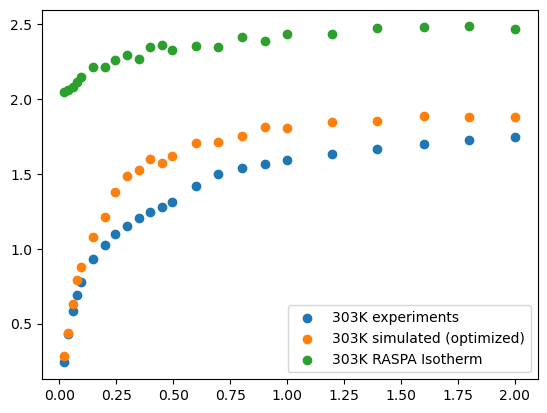

In [169]:
Transfer_unit = 2.7719416667/5.6100437023 
arr_3 = np.loadtxt("/home/yutao/dataset/exp_303.txt", delimiter=',')
plt.scatter(arr_3[:,0], Transfer_unit*arr_3[:,1], label = r"303K experiments")

pressure_list =[
            0.021648873072361,
            0.038256227758007,
            0.059015421115065,
            0.077698695136418,
            0.09638196915777,
            0.14827995255042,
            0.20017793594306,
            0.24584816132859,
            0.29774614472123,
            0.34756820877817,
            0.39739027283511,
            0.44928825622776,
            0.49495848161329,
            0.60083036773428,
            0.69839857651246,
            0.80219454329775,
            0.90183867141163,
            0.99733096085409,
            1.1986951364176,
            1.3959074733096,
            1.5993475682088,
            1.7986358244365,
            2.0020759193357
        ]

loading_ls = [
            0.5301596867559,
            1.6439054244801,
            2.5769834747859,
            3.048750825226,
            3.3212421477618,
            3.5154022875732,
            3.7237669815363]

loading_new_ls = [
            0.56926905962217,
            0.88036378785215,
            1.2714012975129,
            1.6072134492684,
            1.7802916319374,
            2.1904059702588,
            2.459561658795,
            2.7992154117224,
            3.0114966646497,
            3.0858550698129,
            3.2437167643905,
            3.189746954211,
            3.2827511790597,
            3.4500950694717,
            3.4664921472941,
            3.550295269092,
            3.6728329733781,
            3.6595841345688,
            3.7335302701542,
            3.7576480291155,
            3.8163214580124,
            3.8122175036568,
            3.8062021186164
        ]

picked_ls = [0,1,2,3,4,5,6]
#picked_pressure = [pressure_list[i] for i in picked_ls]
picked_pressure = pressure_list[:]
picked_isotherm = [i*Transfer_unit for i in loading_new_ls]
plt.scatter(picked_pressure, picked_isotherm, label = r"303K simulated (optimized)")
plt.scatter(raspa_isotherm["pressure"], np.array(raspa_isotherm["loading_absolute_average"])*Transfer_unit, label = r"303K RASPA Isotherm")
plt.legend()

23 23


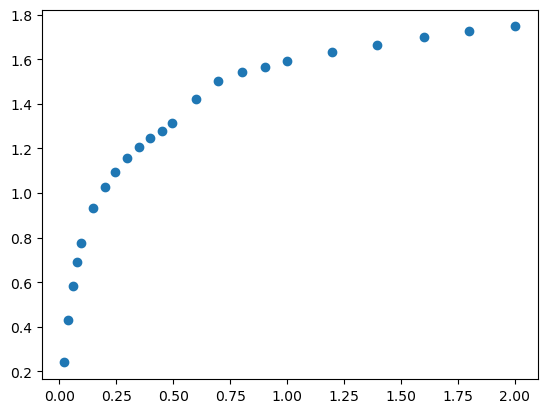

In [82]:
Transfer_unit = 2.7719416667/5.6100437023 

raspa_isotherm = [
            4.1475461760433,
            4.1682795780048,
            4.2119051746019,
            4.2857088897951,
            4.3472569607212,
            4.4867689199957,
            4.4830809830163,
            4.5825316016782,
            4.6522988251158,
            4.5864669004446,
            4.751951830768,
            4.7789817105534,
            4.716635336276,
            4.7685250597767,
            4.747937826006,
            4.8892825099698,
            4.8383709892099,
            4.9311765750692,
            4.9275111254882,
            5.0058460562137,
            5.0193160212084,
            5.0315604218775,
            5.0003816129398
        ]

pressure_list = [
            0.021648873072361,
            0.038256227758007,
            0.059015421115065,
            0.077698695136418,
            0.09638196915777,
            0.14827995255042,
            0.20017793594306,
            0.24584816132859,
            0.29774614472123,
            0.34756820877817,
            0.39739027283511,
            0.44928825622776,
            0.49495848161329,
            0.60083036773428,
            0.69839857651246,
            0.80219454329775,
            0.90183867141163,
            0.99733096085409,
            1.1986951364176,
            1.3959074733096,
            1.5993475682088,
            1.7986358244365,
            2.0020759193357
        ]
print(len(pressure_list), len(raspa_isotherm))
arr_3 = np.loadtxt("/home/yutao/dataset/exp_303.txt", delimiter=',')
plt.scatter(arr_3[:,0], Transfer_unit*arr_3[:,1], label = r"303K experiments")

picked_ls = [0, 3, 6, 9, 12, 15, 18]
picked_pressure = [pressure_list[i] for i in picked_ls]
picked_isotherm = [arr_3[i,1]*Transfer_unit for i in picked_ls]

def is_close_to_list(value, value_list):
    for list_value in value_list:
        relative_error = abs((value - list_value) / list_value)
        if relative_error < 0.01:
            return 1
    return 0

In [98]:
print(picked_pressure)

[0.021648873072361, 0.077698695136418, 0.20017793594306, 0.34756820877817, 0.49495848161329, 0.80219454329775, 1.1986951364176]


In [83]:
print(picked_isotherm)

[0.24030165348645946, 0.6912047560958835, 1.0260070598298272, 1.2069083045892968, 1.3149090477292786, 1.5417106083232401, 1.633511239992225]


In [135]:
import os
import numpy as np
from utils import scaling_gas, extract_from_raspa, write_scaling_gas
bar = 10**5
dest_path = "/home/yutao/project/MIL-120/traj0/"
traj_ls = os.listdir(dest_path)

isotherm_data = [[],[]] # the first list is for pressure, the second is for loading
jdx = 0 
for traj in extract_from_raspa(traj_ls):
    pdb_file = traj[1]
    if not pdb_file.endswith(".pdb") or 'Movie_framework' not in pdb_file:
        continue
    if not is_close_to_list(float(traj[0])/bar, picked_pressure):
        continue
    isotherm_data[0].append(float(traj[0])/bar)
    pdb_path = os.path.join(dest_path, pdb_file)
    with open(pdb_path) as f:
        lines = f.readlines()
    num_atoms_list = []  # List to store the number of atoms in each structure
    index = 0
    write_idx = 1
    num_atoms = 0  # Variable to store the number of atoms in the current structure
    directory = f"./traj/{jdx+1}"
    jdx += 1
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Directory created:", directory)
    for line in lines:
        if line.startswith("MODEL"):
            if index>=200:
                write_scaling_gas(block_coords, "data/gas.pdb", write_idx, dest_path=directory)
                write_idx += 1
            block_coords = []
            block_Csym = []
            index += 1
            num_atoms_list.append(num_atoms)  # Add the number of atoms to the list
            num_atoms = 0  # Reset the number of atoms for the next structure
        if line.startswith("ATOM"):
            parts = line.split()
            coords = np.array([float(parts[4]), float(parts[5]), float(parts[6])])
            block_coords.append(coords)
            block_Csym.append(parts[-1])
            num_atoms += 1  # Increment the number of atoms
    num_atoms_list.append(num_atoms)  # Add the number of atoms for the last structure
    isotherm_data[1].append(sum(num_atoms_list)/len(num_atoms_list)/3/3/2/3)
    print("Number of atoms in each structure for", pdb_file, ":", num_atoms_list)

Directory created: ./traj/1
Number of atoms in each structure for Movie_framework_1_3.3.2_303.000000_2164.887307_component_CO2_0.pdb : [0, 63, 66, 69, 63, 63, 66, 69, 66, 72, 69, 69, 69, 60, 66, 51, 63, 72, 57, 51, 54, 45, 54, 48, 57, 57, 54, 45, 48, 51, 48, 54, 48, 48, 45, 48, 51, 51, 57, 45, 45, 48, 45, 45, 45, 48, 51, 51, 57, 48, 48, 48, 60, 60, 57, 57, 57, 51, 60, 60, 60, 60, 57, 54, 60, 57, 60, 63, 63, 54, 51, 54, 51, 54, 63, 66, 60, 60, 51, 63, 60, 54, 54, 60, 69, 66, 57, 60, 60, 57, 60, 60, 66, 63, 57, 60, 54, 57, 57, 60, 57, 48, 54, 54, 63, 63, 66, 60, 54, 60, 57, 66, 66, 66, 63, 60, 60, 60, 60, 63, 60, 66, 57, 63, 63, 69, 69, 69, 60, 63, 63, 60, 57, 57, 69, 66, 63, 60, 63, 66, 57, 63, 60, 51, 60, 66, 66, 63, 63, 66, 63, 60, 57, 63, 57, 45, 51, 48, 51, 48, 57, 54, 51, 51, 57, 57, 51, 48, 45, 51, 60, 57, 51, 51, 57, 54, 51, 57, 51, 51, 54, 57, 57, 54, 60, 60, 60, 63, 63, 66, 69, 69, 66, 69, 63, 63, 63, 54, 60, 57, 48, 54, 63, 63, 60, 60, 60, 60, 57, 60, 60, 63, 54, 63, 54, 60, 6

In [143]:
def move_traj(dest_path = "/home/yutao/project/MIL-120/traj0/",picked_pressure=picked_pressure):
    traj_ls = os.listdir(dest_path)
    isotherm_data = [[],[]] # the first list is for pressure, the second is for loading
    jdx = 0 
    for traj in extract_from_raspa(traj_ls):
        pdb_file = traj[1]
        if not pdb_file.endswith(".pdb") or 'Movie_framework' not in pdb_file:
            continue
        if not is_close_to_list(float(traj[0])/bar, picked_pressure):
            continue
        isotherm_data[0].append(float(traj[0])/bar)
        pdb_path = os.path.join(dest_path, pdb_file)
        with open(pdb_path) as f:
            lines = f.readlines()
        num_atoms_list = []  # List to store the number of atoms in each structure
        index = 0
        write_idx = 1
        num_atoms = 0  # Variable to store the number of atoms in the current structure
        directory = f"./traj/{jdx+1}"
        jdx += 1
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("Directory created:", directory)
        for line in lines:
            if line.startswith("MODEL"):
                if index>=150:
                    write_scaling_gas(block_coords, "data/gas.pdb", write_idx, dest_path=directory)
                    write_idx += 1
                block_coords = []
                block_Csym = []
                index += 1
                num_atoms_list.append(num_atoms)  # Add the number of atoms to the list
                num_atoms = 0  # Reset the number of atoms for the next structure
            if line.startswith("ATOM"):
                parts = line.split()
                coords = np.array([float(parts[4]), float(parts[5]), float(parts[6])])
                block_coords.append(coords)
                block_Csym.append(parts[-1])
                num_atoms += 1  # Increment the number of atoms
        #num_atoms_list.append(num_atoms)  # Add the number of atoms for the last structure
        #isotherm_data[1].append(sum(num_atoms_list)/len(num_atoms_list)/3/3/2/3)
        #print("Number of atoms in each structure for", pdb_file, ":", num_atoms_list)
    return isotherm_data

In [144]:
isotherm_data = move_traj()

In [11]:
def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

In [145]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)

In [84]:
# input the trajectory file and compute energy for each frame:

Trajectory_length = 80
Number_points = len(picked_ls)
traj_dict = {}

# I have alreay generated a trajectory example
dest_path = "./traj/"
traj_ls = os.listdir(dest_path)
create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
ff = app.ForceField("custom_forcefield.xml")

# Filter out file names and keep only directory names
dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]

for directory in dir_names:
    idx = int(directory)
    traj_dict[idx] = {'experiment': {'pressure': picked_pressure[idx-1], 'loading': picked_isotherm[idx-1]}, 'structure': [], 'refer_energy':[], 'loading':[]}
    gas_dir = os.path.join(dest_path, directory)
    for gas_path in os.listdir(gas_dir)[::100]:
        topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
        ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)
        traj_dict[idx]['structure'].append([topo, pos])
        traj_dict[idx]['loading'].append(num/scaling_factors[0]/scaling_factors[1]/scaling_factors[2]/3)
        traj_dict[idx]['refer_energy'].append(ener_lj)

In [85]:
for key in traj_dict.keys():
    traj_dict[key]['refer_energy'] = jnp.array(traj_dict[key]['refer_energy'])
    traj_dict[key]['loading'] = jnp.array(traj_dict[key]['loading'])
    traj_dict[key]['estimator'] = ReweightEstimator(ref_energies=traj_dict[key]['refer_energy'], temperature=SET_temperature)

In [103]:
import subprocess
script_path = "/home/yutao/project/aiida/applications/"
# Run the script using subprocess
completed_process = subprocess.run(["/home/yutao/.aiida_venvs/aiida/bin/python", "/home/yutao/project/aiida/applications/sample_isotherm.py"], capture_output=True)

# Check the return code
if completed_process.returncode == 0:
    # The script finished successfully
    print("Script finished successfully!")
    # Continue with your program logic here
else:
    # The script encountered an error
    print("Script encountered an error:", completed_process.stderr)
    # Handle the error or exit the program

Script encountered an error: b'Traceback (most recent call last):\n  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/aiida/orm/utils/loaders.py", line 407, in load_entity\n    entity = builder.one()[0]\n  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/aiida/orm/querybuilder.py", line 1129, in one\n    raise NotExistent(\'No result was found\')\naiida.common.exceptions.NotExistent: No result was found\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/yutao/project/aiida/applications/sample_isotherm.py", line 85, in <module>\n    results, node = run_isotherm(load_code(RASPA_CODE_LABEL), load_code(ZEOPP_CODE_LABEL),"MIL-120.cif")  # pylint: disable=no-value-for-parameter\n  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/aiida/orm/utils/loaders.py", line 113, in load_code\n    return load_entity(\n  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/a

In [104]:
import subprocess

script_path = "/home/yutao/project/aiida/applications/sample_isotherm.py"
command = ["/home/yutao/.aiida_venvs/aiida/bin/python", script_path]

# Run the script using subprocess
completed_process = subprocess.run(command, capture_output=True, cwd="/home/yutao/project/aiida/applications")

# Check the return code
if completed_process.returncode == 0:
    # The script finished successfully
    print("Script finished successfully!")
    # Continue with your program logic here
else:
    # The script encountered an error
    print("Script encountered an error:", completed_process.stderr)
    # Handle the error or exit the program

Script encountered an error: b'Traceback (most recent call last):\n  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/aiida/orm/utils/loaders.py", line 407, in load_entity\n    entity = builder.one()[0]\n  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/aiida/orm/querybuilder.py", line 1129, in one\n    raise NotExistent(\'No result was found\')\naiida.common.exceptions.NotExistent: No result was found\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/yutao/project/aiida/applications/sample_isotherm.py", line 85, in <module>\n    results, node = run_isotherm(load_code(RASPA_CODE_LABEL), load_code(ZEOPP_CODE_LABEL),"MIL-120.cif")  # pylint: disable=no-value-for-parameter\n  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/aiida/orm/utils/loaders.py", line 113, in load_code\n    return load_entity(\n  File "/home/yutao/.aiida_venvs/aiida/lib/python3.9/site-packages/a

In [86]:
Trajectory_length = 8

In [87]:
def loss(paramset):

    errors = []
    for idx in range(1, Number_points+1):
        energies = []
        for jdx in range(Trajectory_length):
            ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
            energies.append(ener.reshape((1,)))
        energies = jnp.concatenate(energies)
        weight = traj_dict[idx]['estimator'].estimate_weight(energies)
        reweight_loading = traj_dict[idx]['loading'] * weight
        error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
        errors.append(error.reshape((1,)))
        #print(error)
    errors = jnp.concatenate(errors)
    return jnp.sum(errors)

In [89]:
import optax
optimizer = optax.adam(0.001)
opt_state = optimizer.init(paramset)

In [91]:
v_and_g = jax.value_and_grad(loss, 0)
v, g = v_and_g(paramset)

In [92]:
updates, opt_state = optimizer.update(g, opt_state)
paramset = optax.apply_updates(paramset, updates)
paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)

In [148]:
paramset.parameters

{'LennardJonesForce': {'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
  'epsilon': Array([2.11525, 0.43979, 0.18436, 0.25079, 0.65757, 0.22469], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64)}}

In [159]:
import json
Transfer_energy_unit = 254.152/2.11525
Transfer_length_unit = 10
def update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_1.json'):
    global Transfer_energy_unit, Transfer_length_unit
    element_list = ['Al_', 'C_', 'H_', 'O_']
    params = paramset.parameters
    ff_data = {}
    if len(element_list) != params['LennardJonesForce']['sigma'].shape[0]-2:
        raise ValueError("Length of element list and parameter list does not match")
    sigma_list = params['LennardJonesForce']['sigma'].tolist()
    epsilon_list = params['LennardJonesForce']['epsilon'].tolist()
    for idx in range(len(element_list)):
        ff_data[element_list[idx]] = ['lennard-jones', epsilon_list[idx]*Transfer_energy_unit, sigma_list[idx]*Transfer_length_unit]
    with open(dest_path, 'w') as f:
        json.dump(ff_data, f, indent=4)


In [162]:
update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/UFF.json')
os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_2.json")

0

In [158]:
paramset.parameters

{'LennardJonesForce': {'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
  'epsilon': Array([2.11525, 0.43979, 0.18436, 0.25079, 0.65757, 0.22469], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64)}}

In [160]:
import json
ff_data = '/home/yutao/project/aiida/applications/ff_1.json'
a = json.load(open(ff_data))
print(a)

{'Al_': ['lennard-jones', 254.152, 4.0082], 'C_': ['lennard-jones', 52.84174829452783, 3.4309000000000003], 'H_': ['lennard-jones', 22.151264729937356, 2.5711], 'O_': ['lennard-jones', 30.132977227278097, 3.1180999999999996]}


In [96]:
paramset.parameters

{'LennardJonesForce': {'epsilon': Array([2.11525, 0.43979, 0.18436, 0.25079, 0.65757, 0.22469], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [97]:
paramset.mask

{'LennardJonesForce': {'sigma': Array([1., 1., 1., 1., 0., 0.], dtype=float64),
  'epsilon': Array([1., 1., 1., 1., 0., 0.], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64)}}

In [28]:
len(traj_dict[6]['refer_energy'])

8

In [14]:
print(len(traj_dict[0]['refer_energy']))

KeyError: 0

In [ ]:
estimator = ReweightEstimator(traj_dict[idx]['refer_energy'], volume=traj.unitcell_volumes)

In [24]:
for bin in [1,10,20,100,200,300,400,500,600,700,800]:
    test_list = num_atoms_list[::bin]
    print(f"The bin is : {bin}; ",sum(test_list)/len(test_list)/3/3/2/3)

The bin is : 1;  2.449346405228758
The bin is : 10;  2.447250280583614
The bin is : 20;  2.447777777777778
The bin is : 100;  2.4388888888888887
The bin is : 200;  2.444444444444444
The bin is : 300;  2.4583333333333335
The bin is : 400;  2.351851851851852
The bin is : 500;  2.388888888888889
The bin is : 600;  2.4166666666666665
The bin is : 700;  2.305555555555556
The bin is : 800;  2.305555555555556


In [26]:
for bin in [1,10,20,100,200,300,400,500,600,700,800]:
    test_list = num_atoms_list[600::bin]
    print(f"The bin is : {bin}; ",sum(test_list)/len(test_list)/3/3/2/3)

The bin is : 1;  2.406447898675878
The bin is : 10;  2.4045584045584043
The bin is : 20;  2.405555555555556
The bin is : 100;  2.4027777777777777
The bin is : 200;  2.444444444444444
The bin is : 300;  2.4722222222222223
The bin is : 400;  2.555555555555556
The bin is : 500;  2.555555555555556
The bin is : 600;  2.555555555555556
The bin is : 700;  2.555555555555556
The bin is : 800;  2.555555555555556


In [35]:
print((max(num_atoms_list))/3/3/2/3)
print((min(num_atoms_list))/3/3/2/3)
print((max(num_atoms_list)-min(num_atoms_list))/3/3/2/3)

2.2222222222222223
1.8333333333333333
0.3888888888888889


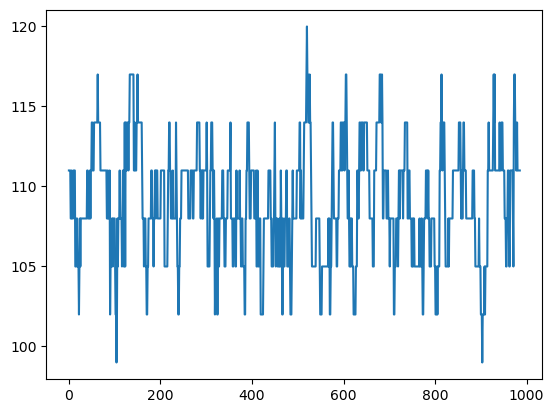

In [34]:
plt.plot(num_atoms_list)